In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import jax

In [128]:
tau = 5
s0 = 20
b0 = 50

def par2rate(pars):
    mu,b = pars
    rates = jax.numpy.array([mu*s0 + b * b0,tau*b*b0])
    return rates

def lhood(data,pars):
    rates = par2rate(pars)
    return jax.scipy.stats.poisson.logpmf(data,rates).sum(axis=-1)

lhood_v = jax.vmap(lhood, in_axes=(None,0))
lhood_z = jax.vmap(lhood, in_axes=(0,0))

grid = xi,yi = np.mgrid[0:5:101j,0.5:1.5:101j]
X = np.swapaxes(grid,0,-1).reshape(-1,2)

data = np.array(par2rate([3.0,1.0]))
zi = -lhood_v(data,X).reshape(101,101).T

In [170]:
si = np.linspace(0,5,101)

def muhat(data):
    n,m = data
    muhat = (n-m/tau)/s0
    return muhat

def bhat(data):
    n,m = data
    return (m/tau)/b0

def parhat(data):
    return jax.numpy.array([muhat(data),bhat(data)])

def bhathat(mu,data):
    n,m = data
    part1 = (n+m-(1+tau)*mu*s0)/(2*(1+tau)) 
    part2 = (((n+m-(1+tau)*mu*s0))**2 + 4*(1+tau)*m*mu*s0)/(4*(1+tau)**2)
    return (part1 + jax.numpy.sqrt(part2))/b0

def parhathat(mu,data):
    return jax.numpy.array([mu,bhathat(mu,data)])

mus = np.linspace(0,5)
bhh = bhathat(mus,data)
bhathat(3.0,data)

DeviceArray(1., dtype=float32)

In [253]:
samples = sps.poisson(par2rate([3.0,1.5])).rvs((4000,2))

In [254]:
phh = np.array(jax.vmap(parhathat, in_axes=(None,0))(3.0,samples))
pht = np.array(jax.vmap(parhat, in_axes=(0,))(samples))

In [255]:
def lrt_stat(mu,data):
    phh = np.array(jax.vmap(parhathat, in_axes=(None,0))(3.0,samples))
    pht = np.array(jax.vmap(parhat, in_axes=(0,))(samples))
    t = -2*(
        lhood_z(data,phh) - lhood_z(data,pht)
    )
    return t,phh,pht

t,phh,pht = lrt_stat(3.0,samples)

In [256]:
phh[0],pht[0]

(array([3.       , 1.5661031], dtype=float32),
 array([3.15, 1.56], dtype=float32))

In [257]:
lhood(samples[0],phh[0]) - lhood(samples[0],pht[0])

DeviceArray(-0.02919006, dtype=float32)

In [258]:
lhood_z(samples[:],phh[:]) - lhood_z(samples[:],pht[:])

DeviceArray([-0.02914429, -2.410553  , -0.08886719, ..., -0.0546875 ,
             -0.4533081 , -0.3653412 ], dtype=float32)

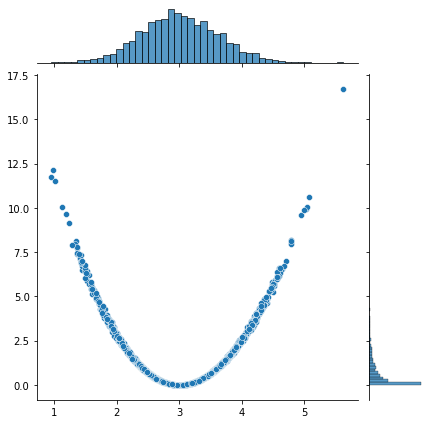

In [259]:
sns.jointplot(pht[:,0],t);

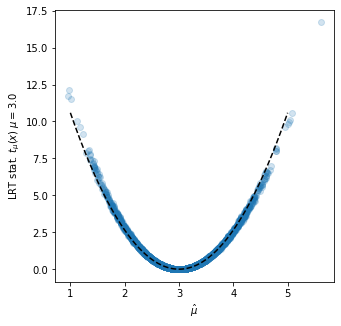

In [260]:
var = np.sqrt(np.var(pht[:,0]))
muhats = np.linspace(1,5,1001)
asympt = (muhats-3.0)**2/var**2
plt.scatter(pht[:,0],t, alpha = 0.2)
plt.plot(muhats,asympt, c = 'k', linestyle='dashed')
plt.xlabel(r'$\hat{\mu}$')
plt.ylabel(r'LRT stat. $t_\mu(x)\; \mu=3.0$')
plt.gcf().set_size_inches(5,5)

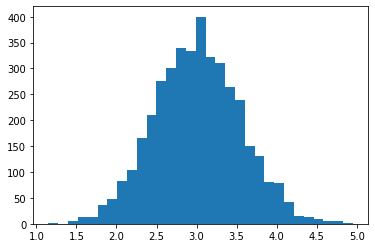

In [197]:
plt.hist(pht[:,0],bins = 31);

Text(0.5, 32.99999999999995, '$\\hat{\\mu}$')

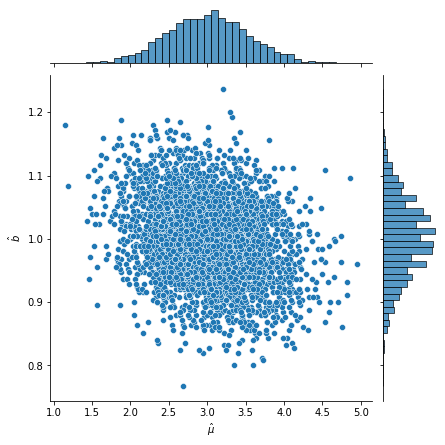

In [201]:
import seaborn as sns
h = sns.jointplot(pht[:,0],pht[:,1])
h.ax_joint.set_ylabel(r'$\hat{b}$')
h.ax_joint.set_xlabel(r'$\hat{\mu}$')

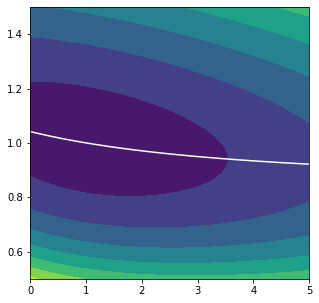

In [77]:
plt.contourf(xi,yi,zi)
plt.plot(mus,bhh,c = 'w')
plt.gcf().set_size_inches(5,5)

In [272]:
sps.chi2(df = 1).ppf(sps.norm(0,1).cdf(1)-sps.norm(0,1).cdf(-1))

0.9999999999999993

In [271]:
sps.norm(0,1).cdf(1)-sps.norm(0,1).cdf(-1)

0.6826894921370859